In [1]:
##library tidyverse, etc.
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
##Load Data
full_data <- read_csv("../data/processed/training_target_df_20241108-123515.csv")

head(full_data)


Rows: 9900 Columns: 20
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (20): Date, State_fips, Fips, Pop, State_pop, Ratio, Proj_state_inc_deat...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Date,State_fips,Fips,Pop,State_pop,Ratio,Proj_state_inc_deaths,True_state_inc_deaths,True_county_cum_deaths,True_county_inc_deaths,Naive_proj_deaths,Naive_true_deaths,True_county_inc_deaths_tm_4,True_county_inc_deaths_tm_5,True_county_inc_deaths_tm_6,True_county_inc_deaths_tm_7,True_county_inc_deaths_tm_8,True_county_inc_deaths_tm_9,True_county_inc_deaths_tm_10,True_county_inc_deaths_tm_11
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20200620,37,37001,169185,10367022,0.01631954,122.9524,104,35,3,2.006526,1.697232,NA,NA,NA,NA,NA,NA,NA,NA
20200627,37,37001,169185,10367022,0.01631954,100.3087,95,36,1,1.636991,1.550356,NA,NA,NA,NA,NA,NA,NA,NA
20200704,37,37001,169185,10367022,0.01631954,119.3991,80,37,1,1.948538,1.305563,NA,NA,NA,NA,NA,NA,NA,NA
20200711,37,37001,169185,10367022,0.01631954,100.1191,106,37,0,1.633897,1.729871,NA,NA,NA,NA,NA,NA,NA,NA
20200718,37,37001,169185,10367022,0.01631954,120.1763,133,39,2,1.961222,2.170498,NA,NA,NA,NA,NA,NA,NA,NA
20200725,37,37001,169185,10367022,0.01631954,131.0000,148,40,1,2.137859,2.415291,NA,NA,NA,NA,NA,NA,NA,NA


First make a super simple poisson model from projected state deaths with county population as offset. 

In [3]:
full_data <- full_data%>%filter(True_county_inc_deaths>=0)

In [6]:
mdl_pois_1 <- glm(True_county_inc_deaths ~ Naive_proj_deaths, data=full_data, 
                  family = poisson)

summary(mdl_pois_1)


Call:
glm(formula = True_county_inc_deaths ~ Naive_proj_deaths, family = poisson, 
    data = full_data)

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)       0.6372424  0.0072478   87.92   <2e-16 ***
Naive_proj_deaths 0.0606391  0.0004102  147.82   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 52971  on 9807  degrees of freedom
Residual deviance: 42113  on 9806  degrees of freedom
AIC: 57647

Number of Fisher Scoring iterations: 6


pois_err,naive_err
<dbl>,<dbl>
234563.8,180851.3


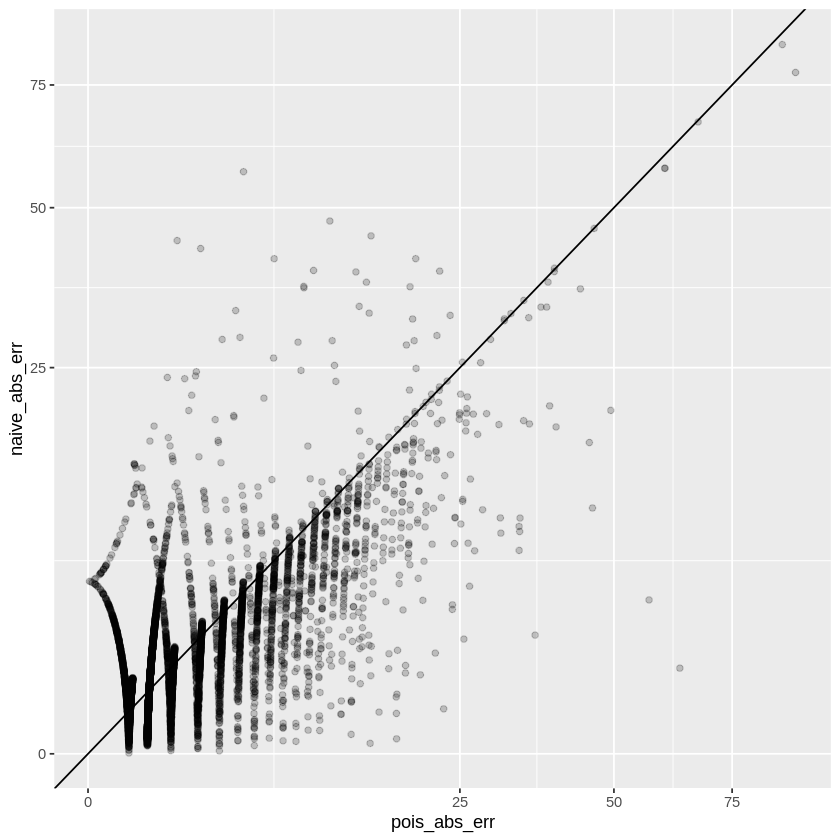

In [7]:
full_data <- full_data %>% 
    mutate(pois_pred =predict(mdl_pois_1),
        pois_abs_err = abs(pois_pred - True_county_inc_deaths) ,
        naive_abs_err = abs(Naive_proj_deaths - True_county_inc_deaths))


full_data %>% ggplot(aes(x=pois_abs_err, y=naive_abs_err)) +
    geom_point(alpha=.2) + scale_y_sqrt() + scale_x_sqrt() +
    geom_abline()



full_data %>% summarize(pois_err = sum(pois_abs_err^2), naive_err = sum(naive_abs_err^2))

